# Pixel-wise Image Segmentation on the Pascal VOC 2012 Dataset

In [1]:
%matplotlib inline
import tensorflow as tf
import keras
import numpy as np
import os

from matplotlib import pyplot
from matplotlib.pyplot import imshow

Using TensorFlow backend.


The post at https://thegradient.pub/semantic-segmentation/ shows a few possibilities for image segmentation.

In [2]:
#https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/datasets/pascal_voc.py
#https://github.com/fizyr/keras-retinanet/blob/master/keras_retinanet/preprocessing/pascal_voc.py

voc_classes = {
    'aeroplane'   : 0,
    'bicycle'     : 1,
    'bird'        : 2,
    'boat'        : 3,
    'bottle'      : 4,
    'bus'         : 5,
    'car'         : 6,
    'cat'         : 7,
    'chair'       : 8,
    'cow'         : 9,
    'diningtable' : 10,
    'dog'         : 11,
    'horse'       : 12,
    'motorbike'   : 13,
    'person'      : 14,
    'pottedplant' : 15,
    'sheep'       : 16,
    'sofa'        : 17,
    'train'       : 18,
    'tvmonitor'   : 19
}


## 1. Downloading the Dataset

In [3]:
# retrieve the VOC dataset
# PASCAL VOC 2012 (http://host.robots.ox.ac.uk/pascal/VOC/voc2012/).
# https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/datasets/pascal_voc.py
# https://github.com/lukas/Keras-FCN-1
# https://github.com/oyam/Semantic-Segmentation-using-Adversarial-Networks
download = False

In [4]:
def untar(filename, destination_folder, is_zipped=False):
    return "tar -C %s -%sxvf %s" % (destination_folder, "z" if is_zipped else "", filename)

In [5]:
# original PASCAL VOC 2012
# https://github.com/oyam/Semantic-Segmentation-using-Adversarial-Networks/blob/master/setup/download_dataset.py
if download:
    !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar # 2 GB
    !mkdir data
    untar("VOCtrainval_11-May-2012.tar", "data", is_zipped=False)
    !tar -C data -xvf VOCtrainval_11-May-2012.tar

## 2. Loading the dataset

### 2.1 Setting the data paths

In [6]:
global_path = "/Users/andreamonacchi/Documents/workspace/img-notebooks"
base_path = "data/VOCdevkit/VOC2012/"

x_subpath = "JPEGImages"
y_class_subpath = "SegmentationClass"
y_obj_subpath = "SegmentationObject"

img_path = os.path.join(base_path, x_subpath)
segmentation_class_path = os.path.join(base_path, y_class_subpath) 
segmentation_obj_path = os.path.join(base_path, y_obj_subpath)

### 2.2 Set a common size for all dataset images

In [7]:
# set the expected size for the dataset images
img_w = 512 # 512/2/2/2/2/2 = 16 px
img_h = 320 # 304/2/2/2/2/2 = 10 px
target_size =(img_w,img_h)

### 2.3 Extracting the file names from the data

In [8]:
import os
img_filenames = os.listdir(img_path)
print "Total image files", len(img_filenames)
img_filenames[:2]
extension_sources = ".jpg"
img_filenames = [f.split(".")[0] for f in img_filenames]

Total image files 17125


Group images by type, since i noticed that some did not match across folders:

In [9]:
segmentation_class_filenames = os.listdir(segmentation_class_path)
segmentation_obj_filenames = os.listdir(segmentation_obj_path)
print "segmentation_class_filenames", len(segmentation_class_filenames), "example:", segmentation_class_filenames[:2]
print "segmentation_obj_filenames", len(segmentation_obj_filenames), "example:", segmentation_obj_filenames[:2]

extension_targets = ".png"
segmentation_class_filenames = [f.split(".")[0] for f in segmentation_class_filenames]
segmentation_obj_filenames = [f.split(".")[0] for f in segmentation_obj_filenames]

segmentation_class_filenames 2913 example: ['2007_000032.png', '2007_000033.png']
segmentation_obj_filenames 2913 example: ['2007_000032.png', '2007_000033.png']


Select only those images common for all datasets:

In [10]:
img_filenames = [i for i in img_filenames if i in segmentation_class_filenames and i in segmentation_obj_filenames]
print "Raw images", len(img_filenames)

Raw images 2913


### 2.4 Splitting in test and train sets

In [11]:
from sklearn.model_selection import train_test_split
seed = 1234
train, test = train_test_split(img_filenames, test_size=0.33, random_state=seed)
print "train size", len(train)
print "test size", len(test)

train size 1951
test size 962


### 2.6 Load the dataset
We define hereby functions to load the dataset either directly in RAM in a array format, which might result too heavy given limited memory requirements, or as batch generator which can be directly passed to the model training function. Let's then select firstly hereby how to carry out this process:

Should we use a python generator instead of a batch load of the entire set?

In [111]:
train_using_generator = True

Do we want the class (true) or the object segmentation?

In [112]:
segmentation_class = False

#### 2.6.1 Load dataset completely

Define a function to load and resize the entire dataset (heavy!):

In [15]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator

def load_from_path(path, resize_to=None):
    img = load_img( path )
    if resize_to is not None:
        #print "Resized from", img.width, img.height, "to", resize_to[0], resize_to[1]
        img = img.resize((resize_to[0], resize_to[1]))
    return img_to_array( img )

def load_resize(path, resize_to):
    img = tf.image.decode_jpeg(path)
    print "img_type", type(img)
    resized_img = tf.image.resize_images(img, (resize_to[0], resize_to[1]))
    print "resized_img_type", type(resized_img)
    resized_img = tf.cast(resized_img, np.uint8).eval()
    
    #return img_to_array( resized_img )
    return resized_img

def get_train_test_sets(x_train,
                        x_test,
                        segmentation_class_files_train,
                        segmentation_class_files_test,
                        segmentation_obj_files_train,
                        segmentation_obj_files_test,
                        segmentation_class=False):
    """
        Populate x_train and x_test with all images available in the dataset (memory consuming)
    """
    for img_name in train: #[:10]:
        x_train.append(load_from_path(os.path.join(img_path,
                                                   img_name+extension_sources),
                                      resize_to=target_size ) )
        if segmentation_class:
            segmentation_class_files_train.append(load_from_path(os.path.join(segmentation_class_path,
                                                                              img_name+extension_targets),
                                                                 resize_to=target_size) )
        else:
            segmentation_obj_files_train.append(load_from_path(os.path.join(segmentation_obj_path,
                                                                            img_name+extension_targets),
                                                               resize_to=target_size) )

    for img_name in test: #[:10]:
        x_test.append(load_from_path(os.path.join(img_path,
                                                  img_name+extension_sources),
                                    resize_to=target_size))
        if segmentation_class:
            segmentation_class_files_test.append(load_from_path(os.path.join(segmentation_class_path,
                                                                             img_name+extension_targets),
                                                                resize_to=target_size) )
        else:
            segmentation_obj_files_test.append(load_from_path(os.path.join(segmentation_obj_path, 
                                                                           img_name+extension_targets),
                                                              resize_to=target_size) )

    x_train = np.asarray(x_train)
    print x_train.shape
    x_test = np.asarray(x_test)

    segmentation_class_files_train = np.asarray(segmentation_class_files_train)
    print segmentation_class_files_train.shape
    segmentation_class_files_test = np.asarray(segmentation_class_files_test)
    print segmentation_class_files_test.shape

    segmentation_obj_files_train = np.asarray(segmentation_obj_files_train)
    print segmentation_obj_files_train.shape
    segmentation_obj_files_test = np.asarray(segmentation_obj_files_test)
    print segmentation_obj_files_test.shape
    
    return x_train, x_test, segmentation_class_files_train, segmentation_class_files_test, segmentation_obj_files_train, segmentation_obj_files_test
    
if not train_using_generator:
    x_train = [] 
    x_test = [] 

    segmentation_class_files_train = [] 
    segmentation_class_files_test = []

    segmentation_obj_files_train = []
    segmentation_obj_files_test = []
    
    x_train, x_test, segmentation_class_files_train, segmentation_class_files_test, segmentation_obj_files_train, segmentation_obj_files_test = get_train_test_sets(x_train, x_test, segmentation_class_files_train, segmentation_class_files_test, segmentation_obj_files_train, segmentation_obj_files_test, segmentation_class=False)

In [16]:
if not train_using_generator:
    print'x_train shape:', x_train.shape

    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        imshow(x_train[i])
        #imgplot = pyplot.imshow(x_train[i])

In [17]:
if not train_using_generator:
    print'segmentation_obj_files_train shape:', segmentation_obj_files_train.shape

    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        imshow(segmentation_obj_files_train[i])
        #imgplot = pyplot.imshow(x_train[i])

#### 2.6.2 Load dataset using Python generators (lightweight)

To minimize the memory that would be necessary to load the entire dataset, we use Python generators to only return batch_size subsets of the dataset during the training process. To achieve this, we use the file names identified when splitting in test and train to move the original images and their related target (i.e., segmented class or object) to a directory structure as follows:
* a "Preprocessed" folder is created as destination path for the preprocessed images
* a "train" directory is created along with a "test" directory
* for both "train" and "test" we have the respective "x" (i.e., original) and "y" (i.e., segmented) images
* the ImageDataGenerator requires a bunch of folders (one for each class) to allow for the flow_from_directory method, we therefore create an "all_classes" folder in each of the mentioned data folders (i.e., train/x, train/y, test/x, test/y) to group them all

In [12]:
def get_target_paths(destination_path):
    """
        returns the paths to be used to store the train and test data when rearranging the initial dataset
    """
    target_x_train = os.path.join(destination_path, "train", "x")
    target_y_train = os.path.join(destination_path, "train", "y")
    target_x_test = os.path.join(destination_path, "test", "x")
    target_y_test = os.path.join(destination_path, "test", "y")
    return target_x_train, target_y_train, target_x_test, target_y_test
    
def rearrange_set(train, test, 
                  common_source_path, 
                  x_subpath, y_subpath, destination_path,
                  subset = -1,
                  extension_sources = ".jpg", extension_targets = ".png"):
    """
        Create a copy of the initial dataset, so as to have the split train and test in different folders
    """
    # set paths
    source_x = os.path.join(common_source_path, x_subpath)
    source_y = os.path.join(common_source_path, y_subpath)
    
    target_x_train, target_y_train, target_x_test, target_y_test = get_target_paths(destination_path)
    target_x_train = os.path.join(target_x_train, "all_classes")
    target_y_train = os.path.join(target_y_train, "all_classes")
    target_x_test = os.path.join(target_x_test, "all_classes")
    target_y_test = os.path.join(target_y_test, "all_classes")
    
    # create destination_path if it does not yet exist
    if not os.path.exists(destination_path): # os.path.isdir(destination_path):
        # create destination folders
        os.makedirs(target_x_train)
        os.makedirs(target_y_train)
        os.makedirs(target_x_test)
        os.makedirs(target_y_test)
    # we need to copy the images from x_path to destination_path/x_path
    from shutil import copyfile
    # copy all train images
    for t in train[:subset]:
        # copy t for x_train and y_train to the target path
        sfx = os.path.join(source_x, t+extension_sources)
        tfx = os.path.join(target_x_train, t+extension_sources)
        sfy = os.path.join(source_y, t+extension_targets)
        tfy = os.path.join(target_y_train, t+extension_targets)
        #print "copying from ", sfx, "to", target_x_train
        copyfile(sfx, tfx)
        #print "copying from ", sfy, "to", target_y_train
        copyfile(sfy, tfy)
    # copy all test images
    for t in test[:subset]:
        # copy t for x_test and y_test to the target path
        sfx = os.path.join(source_x, t+extension_sources)
        tfx = os.path.join(target_x_test, t+extension_sources)
        sfy = os.path.join(source_y, t+extension_targets)
        tfy = os.path.join(target_y_test, t+extension_targets)
        #print "copying from ", sfx, "to", target_x_test
        copyfile(sfx, tfx)
        #print "copying from ", sfy, "to", target_y_test
        copyfile(sfy, tfy)

Below we call the rearrange_set to move the test and train images according to the split set previously calculated. The subset parameter can be used to limit the process to only a specific number of images.

In [13]:
# path where to store the new dataset
destination_path = os.path.join(base_path,"Preprocessed")    

target_x_train, target_y_train, target_x_test, target_y_test = get_target_paths(destination_path)    
# rearrange images so that the files are in specific folders for test and train data
rearrange_set(train, test, 
              subset=20, # limit the amount of images to copy from the initial set (no limit when -1)
              common_source_path=base_path,
              x_subpath=x_subpath, 
              y_subpath=y_class_subpath if segmentation_class else y_obj_subpath, 
              destination_path=destination_path)

Let's now define functions to load the rearranged data:

In [18]:
def get_imageset_batch_generator(x_path, y_path, resize_to, batch_size=1, seed=1234):
    """
        Return a generator for the raw images (x) and the target (y)
        Each time the function is created a new generator is created, to return batch_size images
    """
    # https://keras.io/preprocessing/image/#flow_from_directory
    print "Inspecting", x_path, "and", y_path
    datagenerator = ImageDataGenerator()
    #"categorical" will be 2D one-hot encoded labels,
    #"binary" will be 1D binary labels, 
    #"sparse" will be 1D integer labels,
    #"input" will be images identical to input images (mainly used to work with autoencoders).
    #"None, no labels are returned (just batching)
    x_gen = datagenerator.flow_from_directory(x_path, 
                                             target_size=(resize_to[1], resize_to[0]), 
                                              color_mode='rgb',
                                              classes=None, 
                                              class_mode=None,
                                              batch_size=batch_size, 
                                              shuffle=True, 
                                              seed=seed)
    y_gen = datagenerator.flow_from_directory(y_path, 
                                              target_size=(resize_to[1], resize_to[0]), 
                                              color_mode='rgb',
                                              classes=None, 
                                              class_mode=None,
                                              batch_size=batch_size, 
                                              shuffle=True, 
                                              seed=seed)
    return x_gen, y_gen

from itertools import izip
def zip_xy_gens(x_gen, y_gen):
    """
        Return a generator from the 2 individual generators
    """
    for x, y in izip(x_gen, y_gen):
        yield x, y

In [31]:
# set the batch_size for the example
batch_size = 5

In [19]:
# target_x_train, target_y_train, target_x_test, target_y_test
x_train_gen, y_train_gen = get_imageset_batch_generator(x_path=target_x_train, y_path=target_y_train,
                                                        resize_to=target_size,
                                                        batch_size=batch_size, 
                                                        seed=seed)

Inspecting data/VOCdevkit/VOC2012/Preprocessed/train/x and data/VOCdevkit/VOC2012/Preprocessed/train/y
Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.


Hereby is an example from the pre-processed dataset:

ims size 2
ims[0] (5, 320, 512, 3)
ims[1] (5, 320, 512, 3)


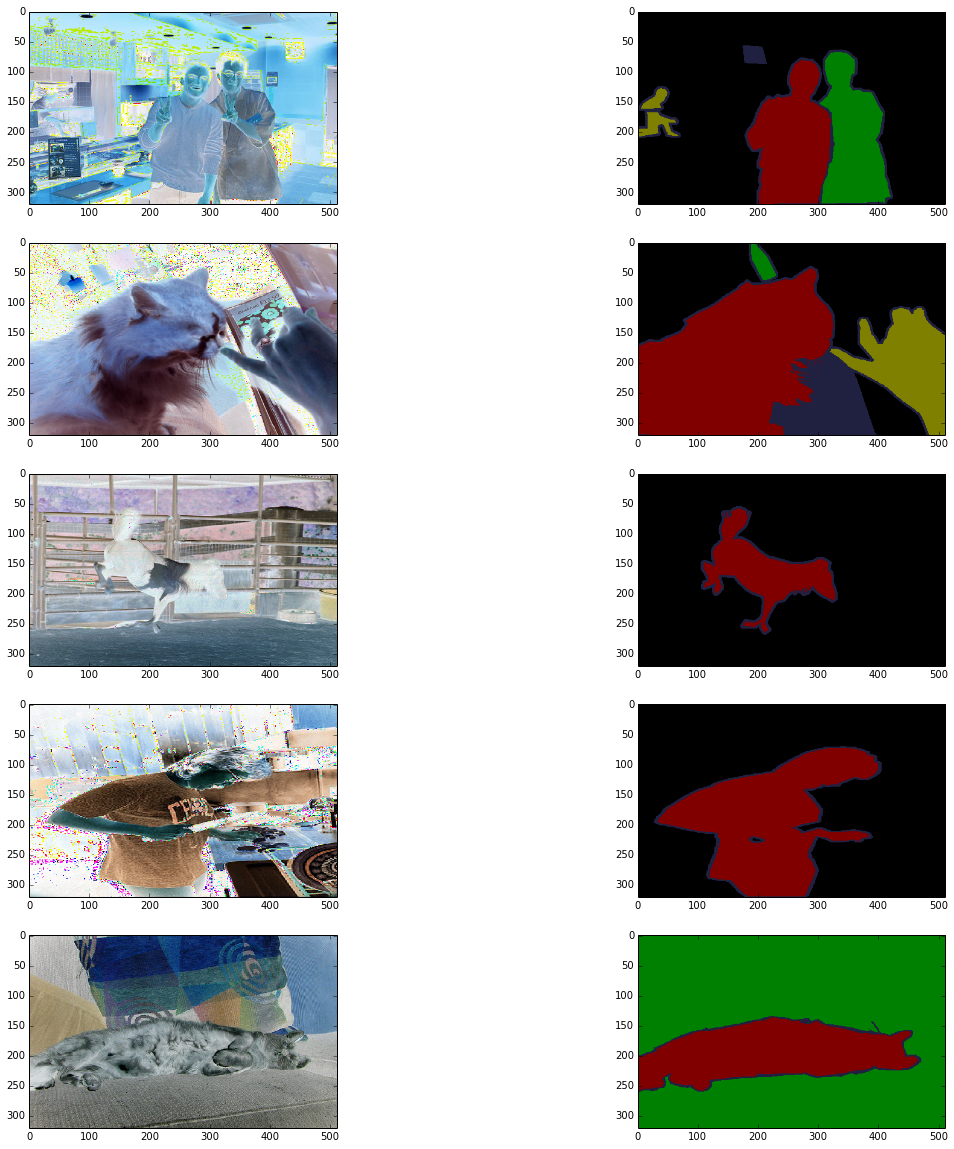

In [107]:
ims = zip_xy_gens(x_train_gen, y_train_gen).next()
print "ims size", len(ims)
for i, v in enumerate(ims):
    print "ims["+str(i)+"]", ims[i].shape

fig=pyplot.figure(figsize=(20,20))

"""
for i, im in enumerate(ims):
    print i, "shape", im[0].shape
    fig.add_subplot(1, 2, 1+i)
    # plot first picture from the batch
    imshow(im[0])
"""

for r in range(batch_size):
    for c in range(len(ims)):
        fig.add_subplot(batch_size, len(ims), 1+r*len(ims)+c)
        imshow(ims[c][r])

As visible, each time next is called on the overall generator, a batch of batch_size elements is simultaneously returned from the individual generators i) x_train_gen and ii) y_train_gen. We accordingly have:
* ims[0] i.e. x_train_gen
* ims[1] i.e. y_train_gen

### 3. Segmentation using Fully Convolutional Neural Networks

In [281]:
# https://www.cv-foundation.org/openaccess/content_cvpr_2015/app/2B_011.pdf

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.constraints import maxnorm
from keras.optimizers import SGD, rmsprop
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D


def net_1(nr_channels, d1=None, d2=None):
    """
    # attempt building a network that does not care of the image structure
    """
    model = Sequential()
    model.add(Conv2D(16, (3, 3), 
                     input_shape=(d1, d2, nr_channels),
                     activation='relu', padding="same"))
    #model.add(MaxPooling2D((2, 2), padding="same"))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    #model.add(MaxPooling2D((2, 2), padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    #model.add(MaxPooling2D((2, 2), padding="same"))

    # ** encoded representation **
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
    return model

def add_segnet_stage(model, net_depth, is_encoder=True, num_repetitions=2, is_first_layer=None, kernel_size=(7,7), up_down_sizing=(2,2)):
    if is_encoder:
        # an encoder stage is done as a 2DCNN repeated n times, and 1 Max Pooling layer at the end
        for i in range(num_repetitions):
            if is_first_layer is not None and i == 0:
                model.add(Conv2D(net_depth, kernel_size, input_shape=is_first_layer, activation='relu', padding='same'))
            else:
                model.add(Conv2D(net_depth, kernel_size, activation='relu', padding='same'))
            # batch normalization at the end of each convolution
            model.add(BatchNormalization())
        # (+1) max pooling to half the image size at the end of the stage
        model.add(MaxPooling2D(up_down_sizing, padding="same"))
    else:
        # a decoder stage is done as 1 UpSampling layer and a 2DCNN repeated n times
        # (1+) upsampling at the beginning of the stage
        model.add(UpSampling2D(up_down_sizing))
        for i in range(num_repetitions):
            model.add(Conv2D(net_depth, kernel_size, activation='relu', padding='same'))
            model.add(BatchNormalization())
    return model

def net_Segnet(nr_channels, img_h=None, img_w=None):
    """
        Return the Segnet from https://arxiv.org/pdf/1511.00561.pdf
    """
    model = Sequential()
    # ** ENCODER **
    # ---- stage 1 (2+1) ----
    model = add_segnet_stage(model, net_depth=64, is_encoder=True, num_repetitions=2, is_first_layer=(img_h, img_w, nr_channels))

    # ---- stage 2 (2+1) ----
    model = add_segnet_stage(model, net_depth=128, is_encoder=True, num_repetitions=2)
    # ---- stage 3 (3+1) ----
    model = add_segnet_stage(model, net_depth=256, is_encoder=True, num_repetitions=3)
    # ---- stage 4 (3+1) ----
    model = add_segnet_stage(model, net_depth=512, is_encoder=True, num_repetitions=3)
    # ---- stage 5 (3+1) ----
    model = add_segnet_stage(model, net_depth=512, is_encoder=True, num_repetitions=3)
    
    # ** DECODER **
    # ---- stage 1 (1+3) ----
    model = add_segnet_stage(model, net_depth=512, is_encoder=False, num_repetitions=3)
    # ---- stage 2 (1+3) ----
    model = add_segnet_stage(model, net_depth=512, is_encoder=False, num_repetitions=3)
    # ---- stage 3 (1+3) ----
    model = add_segnet_stage(model, net_depth=256, is_encoder=False, num_repetitions=3)
    # ---- stage 4 (1+2) ----
    model = add_segnet_stage(model, net_depth=128, is_encoder=False, num_repetitions=2)
    # ---- stage 5 (1+2) ----
    model = add_segnet_stage(model, net_depth=64, is_encoder=False, num_repetitions=2)
    
    # softmax layer at the end
    model.add(Conv2D(nr_channels, (3, 3), activation='softmax', padding='same'))
    model.add(BatchNormalization())
    return model


In [282]:
nr_channels = 3
model = net_Segnet(nr_channels, img_h=img_h, img_w=img_w)

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 320, 512, 64)      9472      
_________________________________________________________________
batch_normalization_1 (Batch (None, 320, 512, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 320, 512, 64)      200768    
_________________________________________________________________
batch_normalization_2 (Batch (None, 320, 512, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 160, 256, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 160, 256, 128)     401536    
_________________________________________________________________
batch_normalization_3 (Batch (None, 160, 256, 128)     512       
__________

### 4. Training the model

In [ ]:
np.random.seed(seed)

if train_using_generator:
    # train generator
    x_train_gen, y_train_gen = get_imageset_batch_generator(x_path=target_x_train, y_path=target_y_train,
                                                            resize_to=target_size,
                                                            batch_size=5, seed=seed)
    train_generator = zip_xy_gens(x_train_gen, y_train_gen)
    # validation generator
    x_test_gen, y_test_gen = get_imageset_batch_generator(x_path=target_x_test, y_path=target_y_test,
                                                          resize_to=target_size,
                                                          batch_size=5, seed=seed)
    test_generator = zip_xy_gens(x_test_gen, y_test_gen)
    
    model.fit_generator(train_generator,
                        steps_per_epoch=270,
                        validation_data=test_generator,
                        validation_steps=100,
                        #epochs=1,
                        #verbose=2
                       )
else:
    model.fit(x_train, 
              segmentation_obj_files_train,
              epochs=50,
              batch_size=128,
              shuffle=True,
              validation_data=(x_test, segmentation_obj_files_test))

Inspecting data/VOCdevkit/VOC2012/Preprocessed/train/x and data/VOCdevkit/VOC2012/Preprocessed/train/y
Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.
Inspecting data/VOCdevkit/VOC2012/Preprocessed/test/x and data/VOCdevkit/VOC2012/Preprocessed/test/y
Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.
Epoch 1/1


In [ ]:
# Final evaluation of the model
if train_using_generator:
    scores = model.evaluate(x_test, segmentation_obj_files_test, verbose=0)
else:
    scores = model.evaluate_generator(test_generator) 
    #, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
    
print("Accuracy: %.2f%%" % (scores[1]*100))

### 5. Example segmentation

In [110]:
if not train_using_generator:
    segmented = model.predict(
        # only predict the first element as example
        np.reshape(x_test[0], (1, img_h, img_w, 3))
    )

    pyplot.imshow(
        np.reshape(x_test[0], (1, img_h, img_w, 3))[0]
    )

In [109]:
if not train_using_generator:
    pyplot.imshow(
        np.reshape(segmented, (1, img_h, img_w, 3))[0]
    )